# Dog Classifier using Convolutional Neural Networks and Transfer Learning


In [1]:
import os
import gc
import pickle

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras import Sequential
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten, Dense, BatchNormalization, Activation, Dropout
from keras.layers import Lambda, Input, GlobalAveragePooling2D, BatchNormalization
from keras.utils import to_categorical
from keras.models import Model
from keras.preprocessing.image import load_img

### Reading in labels.csv
The images in the data set are labelled with with an ID. The breed name for a specific ID can be found in the labels.csv dataset. In this cell we load in the the labels.csv dataset, produce a sorted list of all the breed names in the dataset, and produce a dictionary that maps each breed name to a corresponding integer. We do this since the machine can only identify each dog breed as an integer value.

In [2]:
breed_annotations = pd.read_csv("labels.csv")

# Alphabetically sorted list of the breeds of dogs
classes = sorted(breed_annotations['breed'].unique())

# Number of breeds
classes_count = len(classes)

# A dictionary where each breed is mapped to an integer
classes_dict = dict(zip(classes, range(classes_count)))

### Data Preprocessing
In the following cell we define the size of image an that our first layer in the CNN will take.

In [3]:
image_size = (331,331,3)
train_images_directory = os.path.abspath("train")

Here we define a function that will convert the training images into an array of machine readable image data.

In [4]:
def images_to_array(folder_directory, dataframe, target_size=image_size):
    """
    Converts the training images present in folder_directory into an array of 
    machine readable image data using the labels given in dataframe and the target_size
    
    :type folder_directory: str
    :type dataframe: pandas.DataFrame
    :type target_size: tuple of integers
    
    :rtype: numpy.ndarray, numpy.ndarray
    """
    # an array of zeros which will contain the image data
    images_array = np.zeros([len(dataframe), target_size[0], target_size[1], target_size[2]], dtype=np.uint8)
    # an array of zeros which will contain the corresponding label data
    labels_column = np.zeros([len(dataframe), 1], dtype=np.uint8)
    
    for index, image_id in enumerate(tqdm(dataframe['id'].values)):
        
        # image path is the path of the folder containing the image plus the ID of the image
        image_path = os.path.join(folder_directory, image_id + '.jpg')
        # loading image using keras preprocessing module
        image = load_img(image_path, target_size=target_size)
        
        # the image data is mapped to its corresponding location in the array of image data
        images_array[index] = image
        
        # delete the image data as it is no longer needed
        del image
        
        # map the dog breed to the array of labels
        labels_column[index] = classes_dict[dataframe["breed"][index]]
    
    # after for loop, do one-hot encoding on the labels array
    labels_column = to_categorical(labels_column)
    
    return images_array,labels_column

Here we use the function above to preprocess the data for training 

In [5]:
preprocessed_training_data = images_to_array(train_images_directory, breed_annotations)
with open("training_data_pickle.pkl", "wb") as training_pickle:    
    pickle.dump(preprocessed_training_data, training_pickle)

100%|███████████████████████████████████████████████████████████████████████████| 10222/10222 [00:31<00:00, 329.36it/s]


In [6]:
with open("training_data_pickle.pkl","rb") as pickle_in:
    training_data = pickle.load(pickle_in)
X_train,y_train = training_data

In [7]:
assert X_train.shape == (10222,331,331,3)
assert y_train.shape == (10222, 120)

Let's view some dog images from our training data

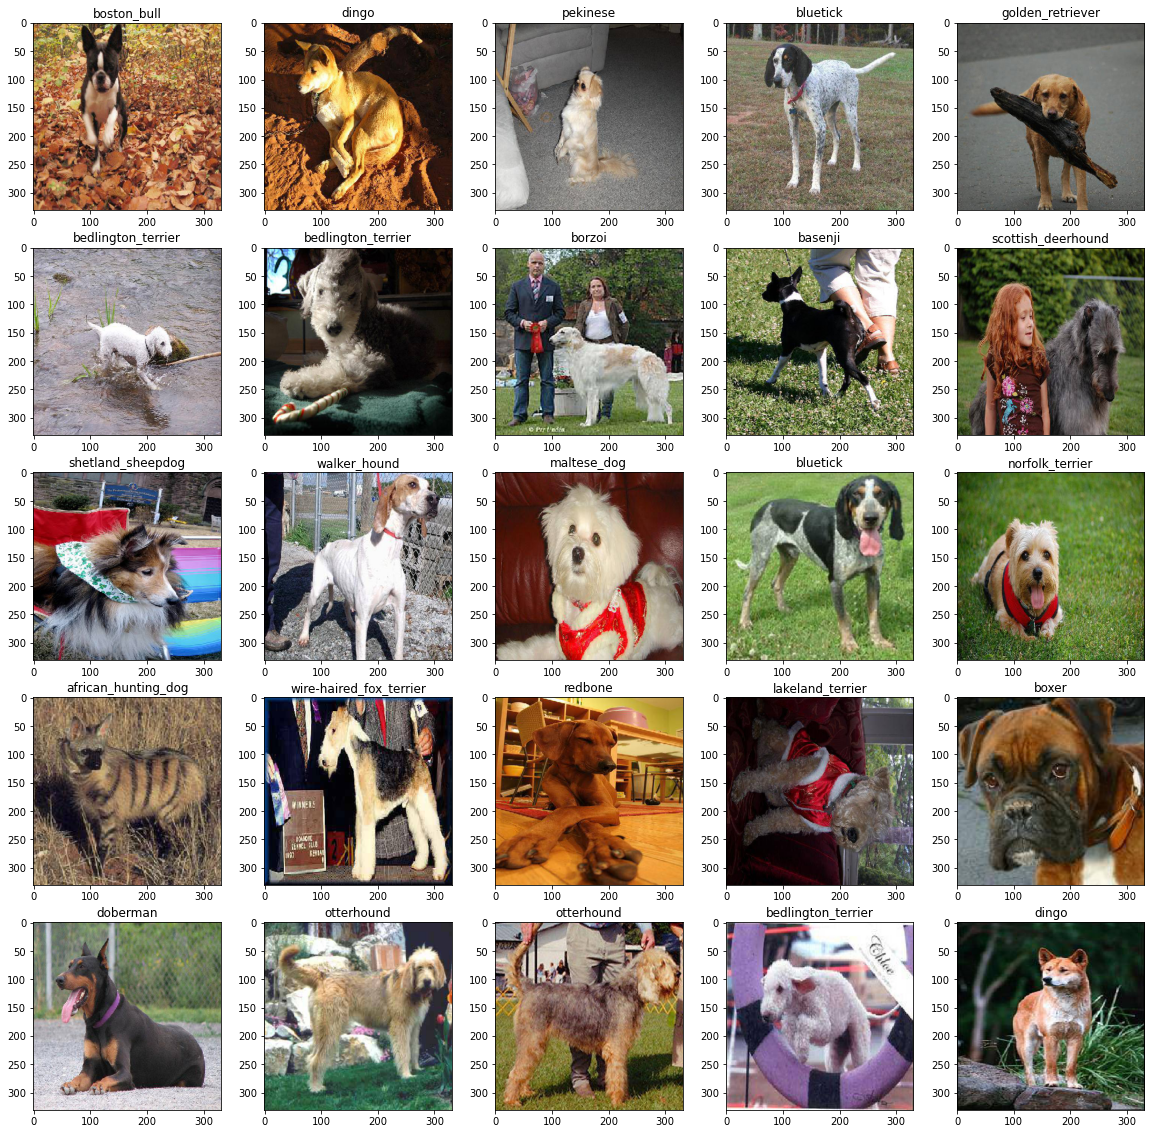

In [8]:
plt.figure(figsize=(20,20))

for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    plt.title(classes[np.where(y_train[i] == 1)[0][0]])
    plt.imshow(X_train[i].astype('int32'))

### Developing the Model

We will be using the combined feature maps of three pretrained models as the base of our ConvNet.
We will then attach a custom head on top of this base.
#### The three pretrained models:
1. Xception
2. Inception V3
3. Inception Resnet V2

First the image data is given to each pretrained model and the feature map is saved in a variable.

A function that returns the feature map produced by the pretrained bases.

In [9]:
def get_features(model_name, model_preprocessor, input_size, data):
    """
    This function returns the feature map produced by the pretrained bases
    
    :type model_name: pretrained model from tensorflow.keras.applications
    :type model_prepocessor: preprocessor for model_name
    :type input_size: tuple of integer
    :type data: numpy.ndarray
    """
    # chained layer calls to specify the model's forward pass
    
    # intialize a keras tensor of shape = input_size
    input_layer = Input(input_size)
    # model preprocessor
    preprocessor = Lambda(model_preprocessor)(input_layer)
    # the pretrained model. Note that weights are set equal to imagenet
    base_model = model_name(weights='imagenet', include_top=False, input_shape=input_size)(preprocessor)
    # pooling layer
    avg = GlobalAveragePooling2D()(base_model)
    
    # groups layers into an object with training and inference features
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    
    # extract features from data
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

In [10]:
from keras.applications.xception import Xception, preprocess_input
xception_preprocessor = preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
inc_resnet_preprocessor = preprocess_input

#####  Extracting Xception Features

In [17]:
xception_features = get_features(Xception,
                                 xception_preprocessor,
                                 image_size, X_train)

with open("xception_features.pkl", "wb") as xception_features_pickle:    
    pickle.dump(xception_features, xception_features_pickle)

320/320 [==============================] - 2059s 6s/step
Feature maps shape:  (10222, 2048)


##### Extracting Inception V3 Features

In [12]:
inception_features = get_features(InceptionV3,
                                  inception_preprocessor,
                                  image_size, X_train)

with open("inception_features.pkl", "wb") as inception_features_pickle:    
    pickle.dump(inception_features, inception_features_pickle)

320/320 [==============================] - 894s 3s/step
Feature maps shape:  (10222, 2048)


##### Extracting Inception ResNet V2 Features

In [13]:
inc_resnet_features = get_features(InceptionResNetV2,
                                   inc_resnet_preprocessor,
                                   image_size, X_train)

with open("inc_resnet_features.pkl", "wb") as inc_resnet_features_pickle:    
    pickle.dump(inc_resnet_features, inc_resnet_features_pickle)

320/320 [==============================] - 4545s 14s/step
Feature maps shape:  (10222, 1536)


##### Concatenating all feature maps
Since training is very expensive, we pickled all the X_train feature maps.

In [19]:
with open("xception_features.pkl", "rb") as xception_features_pickle:    
    xception_features = pickle.load(xception_features_pickle)

with open("inception_features.pkl", "rb") as inception_features_pickle:    
    inception_features = pickle.load(inception_features_pickle)

with open("inc_resnet_features.pkl", "rb") as inc_resnet_features_pickle:    
    inc_resnet_features = pickle.load(inc_resnet_features_pickle)

final_features = np.concatenate([inception_features,
                                 xception_features,
                                 inc_resnet_features,], axis=-1)

print('Final feature maps shape', final_features.shape)

Final feature maps shape (10222, 5632)


##### Defining parameters for ConvNet head

We will be using two callback functions to prevent overfitting. The Learning Rate Annealer and Early Stop

In [20]:
# Learning Rate Annealer
lrr= ReduceLROnPlateau(monitor='val_accuracy', factor=.01, patience=3, min_lr=1e-5,verbose = 1)

# Early Stop
EarlyStop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [21]:
# Hyperparameters
batch_size= 128
epochs=75
learn_rate=.001
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None,  amsgrad=False)

##### Preparing ConvNet

In [22]:
model = Sequential()
# Drop out layer
model.add(Dropout(0.7,input_shape=(final_features.shape[1],)))
# Output layer with as many nodes as classes
model.add(Dense(classes_count,activation='softmax'))

# Compile the model 
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training the model
history = model.fit(final_features, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=0.2,
            callbacks=[lrr,EarlyStop])

Epoch 1/75
64/64 [==============================] - 4s 32ms/step - loss: 2.8212 - accuracy: 0.4648 - val_loss: 0.2682 - val_accuracy: 0.9330
Epoch 2/75
64/64 [==============================] - 1s 19ms/step - loss: 0.2675 - accuracy: 0.9264 - val_loss: 0.2240 - val_accuracy: 0.9340
Epoch 3/75
64/64 [==============================] - 1s 18ms/step - loss: 0.2098 - accuracy: 0.9368 - val_loss: 0.2184 - val_accuracy: 0.9306
Epoch 4/75
64/64 [==============================] - 1s 22ms/step - loss: 0.1770 - accuracy: 0.9453 - val_loss: 0.2097 - val_accuracy: 0.9276
Epoch 5/75
64/64 [==============================] - 1s 23ms/step - loss: 0.1446 - accuracy: 0.9564 - val_loss: 0.2090 - val_accuracy: 0.9311

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 6/75
64/64 [==============================] - 1s 22ms/step - loss: 0.1290 - accuracy: 0.9605 - val_loss: 0.2057 - val_accuracy: 0.9315
Epoch 7/75
64/64 [==============================] - 1s 20ms/step - loss:

Epoch 58/75
64/64 [==============================] - 1s 18ms/step - loss: 0.0994 - accuracy: 0.9720 - val_loss: 0.1876 - val_accuracy: 0.9379
Epoch 59/75
64/64 [==============================] - 1s 18ms/step - loss: 0.1072 - accuracy: 0.9705 - val_loss: 0.1876 - val_accuracy: 0.9374
Epoch 60/75
64/64 [==============================] - 1s 18ms/step - loss: 0.1012 - accuracy: 0.9687 - val_loss: 0.1874 - val_accuracy: 0.9379
Epoch 61/75
64/64 [==============================] - 1s 20ms/step - loss: 0.1060 - accuracy: 0.9707 - val_loss: 0.1876 - val_accuracy: 0.9374
Epoch 62/75
64/64 [==============================] - 1s 20ms/step - loss: 0.1087 - accuracy: 0.9679 - val_loss: 0.1873 - val_accuracy: 0.9369


##### Plotting the training and validation loss and accuracy

<AxesSubplot:>

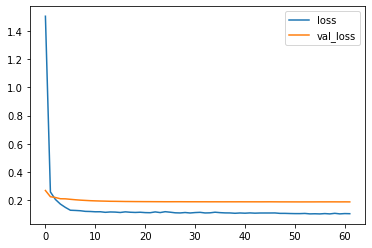

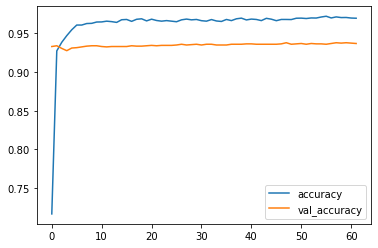

In [23]:
history_frame = pd.DataFrame(history.history)
history_frame.head()
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

As the plots show, the training and validation loss and accuracy improved and eventually leveled off. This signifies that there was no underfitting. The plots also show that the training and validation loss and accuracy remained very close, which means that there was little to no overfitting.

In [24]:
# Save the model
model.save(os.getcwd())

INFO:tensorflow:Assets written to: C:\Users\areel\GitHub\DogClassifier\assets


In [ ]:
# Delete data we no longer need
del X_train, xception_features, inception_features, inc_resnet_features, final_features
gc.collect()

### Let's test our model with a Custom Input

Since we saved our model earlier, let's load our model into a new variable. 

In [25]:
DogClassifier = tf.keras.models.load_model(os.getcwd())

Let's define a function that can take a JPEG image as an input and convert it into a format that our model can use to predict the breed type

In [26]:
def extract_features(image):
    
    # Extract the image features from the pretrained bases
    xception_features = get_features(Xception, xception_preprocessor, (331, 331,3), image)
    inception_features = get_features(InceptionV3, inception_preprocessor, (331, 331,3), image)
    inc_resnet_features = get_features(InceptionResNetV2, inc_resnet_preprocessor, (331, 331,3), image)

    # Concatenate the features
    final_features = np.concatenate([xception_features, inception_features, inc_resnet_features], axis=-1)
     
    # Print the feature map size
    print('Final feature maps shape', final_features.shape)
    
    # Deleting to free up ram memory
    del xception_features
    del inception_features
    del inc_resnet_features
    gc.collect()
    
    
    return final_features

Let's define a function that takes the file name of a JPEG and returns the model's prediction for the image

In [27]:
def image_to_prediction(jpeg):
    image_path = os.path.abspath(jpeg)
    image = load_img(image_path, target_size=(331,331,3))
    image = np.expand_dims(image, axis=0)
    assert image.shape == (1, 331, 331, 3)
    image_features = extract_features(misty)
    prediction = DogClassifier.predict(image_features)
    return classes[prediction.argmax()]

Let's look at an example of a custom image for a dog. Here's my friend's dog, Misty. Misty is a golden retriever.

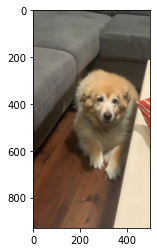

In [28]:
import matplotlib.image as mpimg
misty = mpimg.imread("misty.jpg")
plt.imshow(misty)

In [30]:
image_to_prediction("misty.jpg")

'golden_retriever'

As we can see the model has correctly predicted Misty's breed.